<a href="https://colab.research.google.com/github/FrostyByte/Laser-Harp/blob/master/Drug_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import h5py
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from numba import njit,prange,jit,guvectorize
import numba
import cupy as cp
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score,train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, auc as aucc,plot_roc_curve,recall_score,precision_score,f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import time
import os
from google.colab import drive
from scipy.special import expit 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def counte(y):    
    s=0
    idx1,idx0=[],[]
    for i in np.arange(len(y)):
        if(y[i]==1.0): 
            s+=1
            idx1.append(i)
        else: idx0.append(i)
    return [idx0,idx1,s]


In [5]:
hf = h5py.File('/content/drive/My Drive/Drug_data/Morgan.h5', 'r')
x=np.array(hf.get('fingerprints'))
y=np.array(hf.get('active'))
print(x.shape,y.shape)
c=counte(y)
print('Total active samples=',c[2])


(290893, 2048) (290893, 1)
Total active samples= 405


In [ ]:
pca = PCA(n_components=100)
PC = pca.fit_transform(x)
var=pca.explained_variance_ratio_
print(max(var),sum(var))
x=np.arange(len(var))
plt.bar(x,var)
plt.show()


In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print(x_train.shape,x_test.shape)
del x 
del y

(232714, 2048) (58179, 2048)


In [7]:
scaler=StandardScaler().fit(x_train)


In [8]:
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
c=counte(y_train)
print('No. of active samples=',c[2])

No. of active samples= 326


In [9]:
x_act,y_act=x_train[c[1]],y_train[c[1]]
x_inact,y_inact=x_train[c[0]],y_train[c[0]]
del x_train

print(x_act.shape,x_inact.shape)

(326, 2048) (232388, 2048)


In [10]:

cols_del=[]
for i in np.arange(x_act.shape[1]):
    if x_act[:,i].std()==0.0:
        cols_del.append(i)
print('Number of columns to be deleted=',len(cols_del))

Number of columns to be deleted= 148


In [11]:
def delete_cols(x,col_idx):
    return np.delete(x,col_idx,axis=1)
x_act=delete_cols(x_act,cols_del)
x_test=delete_cols(x_test,cols_del)
x_inact=delete_cols(x_inact,cols_del)
#x_train=delete_cols(x_train,cols_del)
print(x_test.shape,x_act.shape)

(58179, 1900) (326, 1900)


In [12]:
class RMTClassifier(object):
    def __init__(self,threshold=1,train_cutoff=0.95):
        self.threshold=threshold
        self.train_cutoff=train_cutoff
        self.epsilon = None
        self.feature_vecs = None
        self.dim_v= None
        self.p = None
    def fit(self,train_mat):
        n,p=train_mat.shape
        self.p=p
        gamma= p/n
        thresh= ((1+np.sqrt(gamma))**2)*self.threshold
        c_mat=np.dot(train_mat.T,train_mat)/n

        evals,evecs=np.linalg.eig(c_mat)
        idx= evals.argsort()
        idx= idx[::-1]
        evals,evecs= evals[idx],evecs[:,idx]
        

        dim_v= evals[evals>thresh].shape[0]
        feature_vecs= np.ascontiguousarray(evecs[:,:dim_v].T,dtype=np.complex128)
        self.dim_v,self.feature_vecs=dim_v,feature_vecs
        train_mat=np.ascontiguousarray(train_mat,dtype=np.complex128)
        
        trial_mol_proj= np.zeros((self.dim_v,self.p),dtype=np.complex128)
        similarity=find_similarity2(train_mat,trial_mol_proj,feature_vecs)
        similarity.sort()
  
        cutoff_idx= int(self.train_cutoff*len(similarity))
        epsilon= similarity[cutoff_idx]
        self.epsilon= epsilon

    def predict(self,test, epsilon_multiple = 1):
        test=np.ascontiguousarray(test,dtype=np.complex128)
        trial_mol_proj= np.zeros((self.dim_v,self.p),dtype=np.complex128)
        test_similarity=find_similarity2(test,trial_mol_proj,self.feature_vecs)
        
        #predictions= np.array([1 if x<self.epsilon*epsilon_multiple else 0 for x in test_similarity])
        predictions= test_similarity,self.epsilon
        return predictions


@guvectorize(["c16[:],c16[:,:],c16[:,:],f8[:]"], "(p),(dim_v,p), (dim_v,p) -> ()", nopython=True, target="parallel")
def find_similarity2(trial_mol,trial_mol_proj,feature_vecs,similarity):
    dummy=np.zeros_like(trial_mol_proj)
    for idx in prange(feature_vecs.shape[0]):
        dotprod= np.vdot(feature_vecs[idx],trial_mol).real
        dummy[idx]=dotprod*feature_vecs[idx]  
    projection=np.sum(dummy,axis=0).real
    similarity[0]=np.linalg.norm(trial_mol-projection)


"""@njit(parallel=True)
def find_similarity(trial_mol,dim_v,p,feature_vecs):
    trial_mol_proj= np.zeros((dim_v,p),dtype=np.complex128)
    for idx in prange(dim_v):
        dotprod= np.vdot(feature_vecs[idx],trial_mol).real
        trial_mol_proj[idx]=dotprod*feature_vecs[idx]  
    projection=np.sum(trial_mol_proj,axis=0).real
    similarity=np.linalg.norm(trial_mol-projection)
    return similarity"""


<ipython-input-12-e1a3f038966d>:49: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(complex128, 1d, A), array(complex128, 1d, A))
  dotprod= np.vdot(feature_vecs[idx],trial_mol).real


'@njit(parallel=True)\ndef find_similarity(trial_mol,dim_v,p,feature_vecs):\n    trial_mol_proj= np.zeros((dim_v,p),dtype=np.complex128)\n    for idx in prange(dim_v):\n        dotprod= np.vdot(feature_vecs[idx],trial_mol).real\n        trial_mol_proj[idx]=dotprod*feature_vecs[idx]  \n    projection=np.sum(trial_mol_proj,axis=0).real\n    similarity=np.linalg.norm(trial_mol-projection)\n    return similarity'

In [12]:
  t=time.time()
  clf1,clf0=fit_RMT(x_act,x_inact[:1000])
  print(time.time()-t)

NameError: ignored

In [ ]:
#b=projection(np.complex_(x_test[0]),clf1.dim_v,clf1.p,clf1.feature_vecs)
print(a==b)

[ True  True  True ...  True  True  True]


In [13]:
def fit_RMT(x_act,x_inact):
  clf_act=RMTClassifier()
  clf_inact=RMTClassifier()
  clf_act.fit(x_act)
  clf_inact.fit(x_inact)
  return clf_act,clf_inact

def clf_predict(clf_act,clf_inact,x_test,e=1,thresh=True):
  pred1,epsilon1= clf_act.predict(x_test)
  pred0,epsilon0= clf_inact.predict(x_test)
  diff=expit(pred1-pred0)
  epsilon= expit(epsilon1-epsilon0)
  
  if thresh==False: pred=[1 if i<e else 0 for i in diff]
  else: pred=[1 if i<epsilon*e else 0 for i in diff]
  
  return pred
  
def FP_TP_FN_TN(y_test,y_pred):
  y1,y2=y_test.ravel(),y_pred.ravel()
  fp,tp,fn,tn=0,0,0,0
  for i in prange(len(y1)):
    a,b=y1[i],y2[i]
    if(a==1): 
      if(b==1):tp+=1
      else:fn+=1
    else:
      if(b==1):fp+=1
      else:tn+=1
    
  return fp,tp,fn,tn


In [ ]:

 
"""def FP_TP_FN_TN(clf1,clf0,x_test,y_test,multiple):
    #c=counte(y_test)
    #x1=x_test[c[1]]
    #x0=x_test[c[0]]
    #active_pred=clf_predict(clf1,clf0,x1,multiple,thresh=False)
    #inactive_pred=clf_predict(clf1,clf0,x0,multiple,thresh=False)
    y_pred=clf_predict(clf1,clf0,x_test,multiple)
    return """


    

In [ ]:
t0=time.time()
clf_predict(clf1,clf0,x_test[:50000],0)
print(time.time()-t0,'s')


In [14]:
def metric_RMT(clf1,clf0,x_test,y_test,plot=True):
  x,y,p,r,f1,e=[],[],[1],[0],[],[]
  best_f1=0
  arr=np.append(np.logspace(-4,-2,3),np.linspace(0.1,1,20))
  for idx,val in enumerate(arr):
      #if idx%5==0:
          #print(f'progress:{idx}%')
      y_pred=clf_predict(clf1,clf0,x_test,val,thresh=False)
      fp,tp,fn,tn= FP_TP_FN_TN(np.array(y_test),np.array(y_pred))
      tpr=tp/(tp+fn)
      fpr=fp/(fp+tn)
      precision= tp/(tp+fp)
      recall= tpr
      f1_sc=(2*precision*recall)/(precision+recall)
      f1.append(f1_sc)
      p.append(precision)
      r.append(recall)
      e.append(val)
      x.append(fpr)
      y.append(tpr)
      if(best_f1<f1_sc):
        best_f1,i=f1_sc,idx  
  print('ok')
  AUC_ROC,AUC_PR=aucc(x,y),aucc(r,p)
  if(plot==True):
    fig1,fig2=plt.figure(),plt.figure()
    ax1,ax2=fig1.add_subplot(111),fig2.add_subplot(111)
    ax1.set_title('ROC')
    ax1.set_ylabel('True Positive')
    ax1.set_xlabel('False Positive')
    ax1.text(0.75,0.15,f'AUC:{str(np.round(AUC_ROC,4))}')
    ax1.plot(x,y)
    ax1.axis([0,1,0,1])
    ax2.set_title('Precision/Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Recall')
    ax2.text(0.75,0.15,f'AUC-PR:{str(np.round(AUC_PR,4))}')
    ax2.plot(r,p)
    ax2.axis([0,1,0,1])
    plt.show()
  
  return AUC_ROC,AUC_PR,p,r,f1,best_f1,e,i

In [ ]:
clf=RMTClassifier()
t0=time.time()
clf.fit(x_act)
print(time.time()-t0,'s')
pred=clf.predict(x_test)
train_pred=clf.predict(x_act)
inact_pred=clf.predict(x_inact[:50000])
print(time.time()-t0,'s')
print('TPR/Recall on test=',np.mean(train_pred))
print('FPR=',np.mean(inact_pred))


5.9049413204193115 s
192.7643337249756 s
TPR/Recall on test= 0.8971061093247589
FPR= 0.6269


In [ ]:
l=[['e','n_inactive_samples','AUC','Precision','Recall','F1','F1*AUC']]
for n in np.arange(500,12500,1500):
  
  clf1,clf0=fit_RMT(x_act,x_inact[:n])
  for i in np.arange(10):
    t0=time.time()
    pred=clf_predict(clf1,clf0,x_test,i)
    print(((10*(7-((n-500)/1500)))+(9-i))*(time.time()-t0),'s left to finish')
    print('e=',i)
    print(confusion_matrix(y_test,pred))
    auc_sc,prec,recall,f1=roc_auc_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)
    print('AUC=',auc_sc, 'precision= ',prec,'recall= ',recall,'f1= ',f1,'F1*AUC=',f1*auc_sc)
    l.append([i,n,auc_sc,prec,recall,f1,f1*auc_sc])


13457.16244673729 s left to finish
e= 0
[[35265 22833]
 [   22    59]]
AUC= 0.6676933482761567 precision=  0.002577319587628866 recall=  0.7283950617283951 f1=  0.005136464545335829 F1*AUC= 0.003429583210577046
13291.951274871826 s left to finish
e= 1
[[42958 15140]
 [   29    52]]
AUC= 0.6906905700840088 precision=  0.0034228541337546076 recall=  0.6419753086419753 f1=  0.006809402213055719 F1*AUC= 0.004703189896466765
13119.168603181839 s left to finish
e= 2
[[47690 10408]
 [   36    45]]
AUC= 0.688204986976029 precision=  0.004304984215057878 recall=  0.5555555555555556 f1=  0.008543763052971332 F1*AUC= 0.005879860340596414
12988.66981124878 s left to finish
e= 3
[[50619  7479]
 [   43    38]]
AUC= 0.6702025186052173 precision=  0.005055208194758547 recall=  0.4691358024691358 f1=  0.010002632271650434 F1*AUC= 0.006703789341141947
12821.028918027878 s left to finish
e= 4
[[52490  5608]
 [   44    37]]
AUC= 0.6801317824416727 precision=  0.006554472984942427 recall=  0.45679012345679

ok


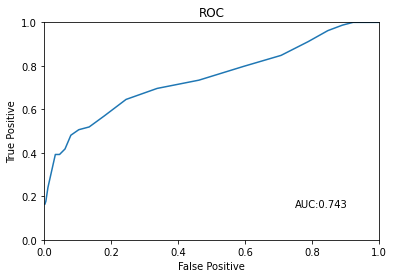

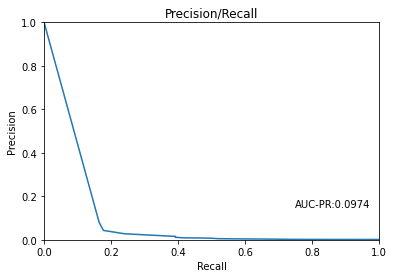

3674.977108001709 s left to finish
e for best f1= 0.0001 best f1= 0.10743801652892562
[[57950   150]
 [   66    13]]
AUC roc= 0.7430424410117868 AUC_PR 0.09744831891182976 precision=  0.07975460122699386 recall=  0.16455696202531644 f1=  0.10743801652892562
ok


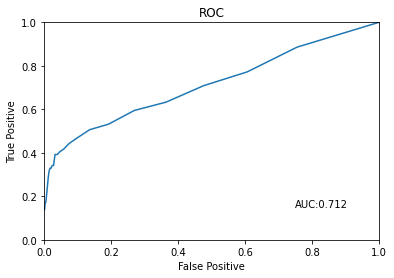

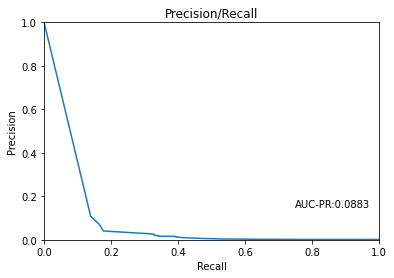

2800.8097293376923 s left to finish
e for best f1= 0.0001 best f1= 0.12154696132596685
[[58009    91]
 [   68    11]]
AUC roc= 0.7119614806422797 AUC_PR 0.08825080632933376 precision=  0.10784313725490197 recall=  0.13924050632911392 f1=  0.12154696132596685
ok


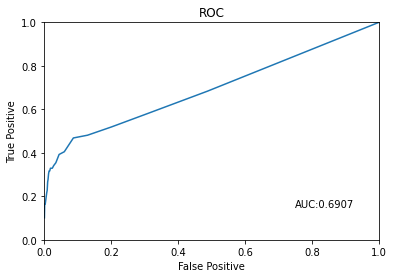

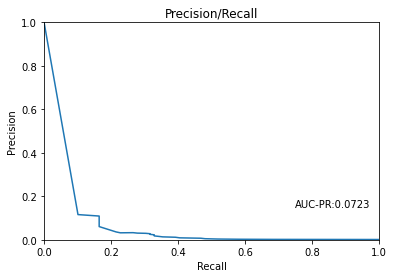

0.0 s left to finish
e for best f1= 0.001 best f1= 0.1313131313131313
[[57994   106]
 [   66    13]]
AUC roc= 0.69070175820824 AUC_PR 0.07228174175431389 precision=  0.1092436974789916 recall=  0.16455696202531644 f1=  0.1313131313131313
ok


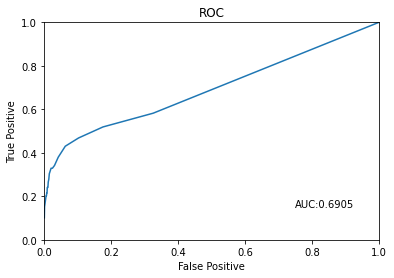

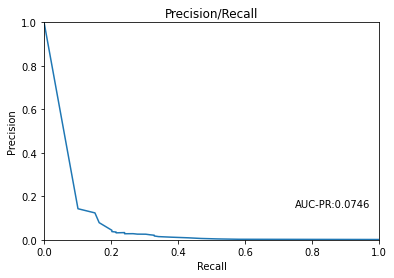

-3910.530655145645 s left to finish
e for best f1= 0.001 best f1= 0.13636363636363635
[[58015    85]
 [   67    12]]
AUC roc= 0.69053988104316 AUC_PR 0.07459867119020258 precision=  0.12371134020618557 recall=  0.1518987341772152 f1=  0.13636363636363635
ok


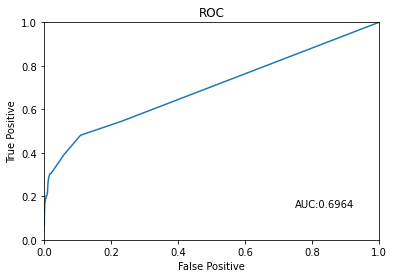

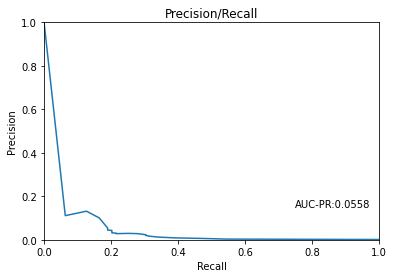

-8608.840184688568 s left to finish
e for best f1= 0.001 best f1= 0.12903225806451615
[[58034    66]
 [   69    10]]
AUC roc= 0.6963662607028477 AUC_PR 0.05577121722517054 precision=  0.13157894736842105 recall=  0.12658227848101267 f1=  0.12903225806451615
ok


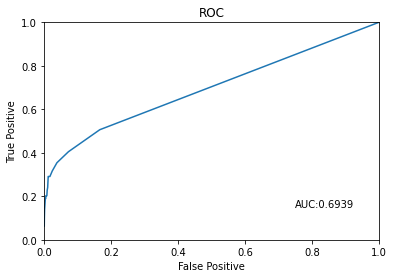

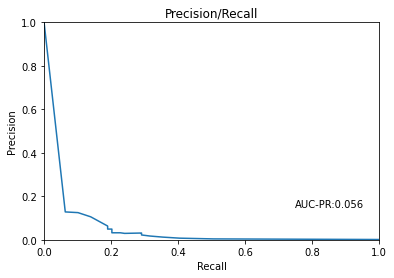

-13909.00006699562 s left to finish
e for best f1= 0.01 best f1= 0.12021857923497267
[[58007    93]
 [   68    11]]
AUC roc= 0.6939442035774199 AUC_PR 0.05604881737661856 precision=  0.10576923076923077 recall=  0.13924050632911392 f1=  0.12021857923497267
ok


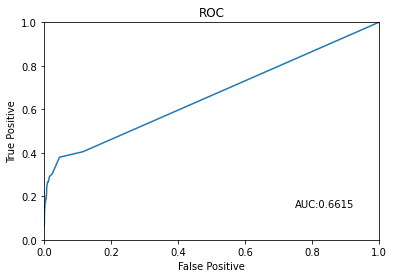

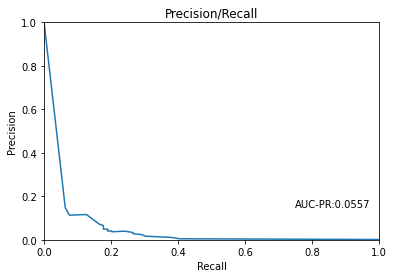

-19843.586565971375 s left to finish
e for best f1= 0.01 best f1= 0.12121212121212123
[[58024    76]
 [   69    10]]
AUC roc= 0.6615026471164948 AUC_PR 0.055692588366939466 precision=  0.11627906976744186 recall=  0.12658227848101267 f1=  0.12121212121212123
ok


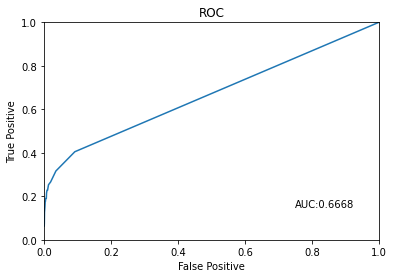

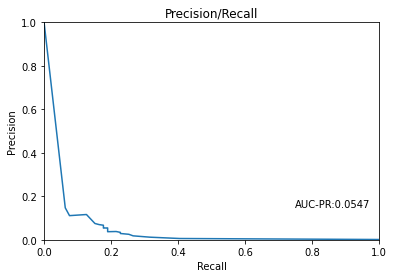

-27005.954751968384 s left to finish
e for best f1= 0.01 best f1= 0.12121212121212123
[[58024    76]
 [   69    10]]
AUC roc= 0.666837512799843 AUC_PR 0.05469684904968854 precision=  0.11627906976744186 recall=  0.12658227848101267 f1=  0.12121212121212123


In [15]:
l=[['e','n_inactive_samples','AUC_roc','AUC_PR','Precision','Recall','F1']]
pr,nlist=[],[]
for n in np.arange(500,12000,1500):
  t0=time.time()
  clf1,clf0=fit_RMT(x_act,x_inact[:n])
  auc_roc,auc_pr,p,r,f1,best_f1,e,idx_bestf1=metric_RMT(clf1,clf0,x_test,y_test)
  pred=clf_predict(clf1,clf0,x_test,e[idx_bestf1],thresh=False)
  print((time.time()-t0)*(2-((n-500)/1500)),'s left to finish')
  print('e for best f1=',e[idx_bestf1],'best f1=',best_f1)
  print(confusion_matrix(y_test,pred))
  prec,recall,f1=precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)
  print('AUC roc=',auc_roc,'AUC_PR',auc_pr, 'precision= ',prec,'recall= ',recall,'f1= ',f1)
  l.append([e,n,auc_roc,auc_pr,prec,recall,best_f1])
  pr.append([e,p,r])
  nlist.append(n)

In [16]:
dat=pd.DataFrame(l[1:],columns=l[0])
dat.to_csv('/content/drive/My Drive/Drug_data/RMT_performance2.csv')

In [17]:
dat2=pd.DataFrame(pr,index=nlist)
dat2.to_csv('/content/drive/My Drive/Drug_data/RMT_performance3.csv')

[[[0.0001,
   0.001,
   0.01,
   0.1,
   0.1473684210526316,
   0.19473684210526315,
   0.24210526315789474,
   0.2894736842105263,
   0.33684210526315794,
   0.38421052631578945,
   0.43157894736842106,
   0.4789473684210527,
   0.5263157894736842,
   0.5736842105263158,
   0.6210526315789474,
   0.6684210526315789,
   0.7157894736842105,
   0.7631578947368421,
   0.8105263157894737,
   0.8578947368421053,
   0.9052631578947369,
   0.9526315789473684,
   1.0],
  [1,
   0.07975460122699386,
   0.043209876543209874,
   0.027616279069767442,
   0.015609264853977844,
   0.01141804788213628,
   0.00900163666121113,
   0.00810753147002347,
   0.006599571027883187,
   0.005212306127637936,
   0.004290617848970252,
   0.0035721790292078167,
   0.0027952835942264688,
   0.0021538918597742126,
   0.0018167661562418895,
   0.001626687384675148,
   0.0015685591041784673,
   0.0015409257719835364,
   0.0015038753711487294,
   0.0014708894226293544,
   0.0014324049898462431,
   0.001404943980081806

In [ ]:
print(confusion_matrix(y_test,pred))
auc_sc,prec,recall,f1=roc_auc_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)
print('AUC=',auc_sc, 'precision= ',prec,'recall= ',recall,'f1= ',f1)


[[47690 10408]
 [   36    45]]
AUC= 0.688204986976029 precision=  0.004304984215057878 recall=  0.5555555555555556 f1=  0.008543763052971332


0.7664473684210527


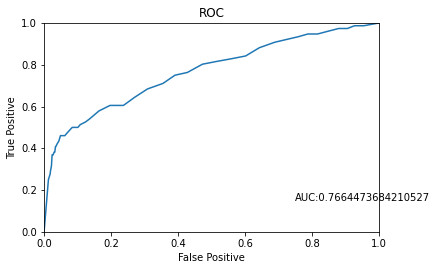

In [ ]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

aucscores,recallsc,precsc,f1sc = [],[],[],[]

for train_index, test_index in kfold.split(x,y):   
    x_tra,x_tst,y_tra,y_tst = x[train_index], x[test_index],y[train_index],y_train[test_index]
    count=counte(y_tra)
    x_1,x_0=x_tra[count[1]],x_tra[count[0]]
    clf1,clf0=fit_RMT(x_1,x_0[:9500])
    pred=clf_predict(clf1,clf0,x_tst,e=2)
    
    print(confusion_matrix(y_tst,pred))
    auc_sc,prec,recall,f1=auc_RMT(clf1,clf0,x_test,y_test),precision_score(y_tst,pred),recall_score(y_tst,pred),f1_score(y_tst,pred)
    aucscores.append(auc_sc)
    precsc.append(prec)
    recallsc.append(recall)
    f1sc.append(f1)
print('AUC=',np.mean(aucscores), 'precision= ',np.mean(precsc),'recall= ',np.mean(recallsc),'f1=',np.mean(f1sc))


KeyboardInterrupt: ignored

In [ ]:
class RMTClassifier(object):
    def __init__(self,threshold=1,train_cutoff=0.95):
        self.threshold=threshold
        self.train_cutoff=train_cutoff
        self.epsilon = None
        self.feature_vecs = None
        self.dim_v= None
        self.p = None
    def fit(self,train_mat):
        n,p=train_mat.shape
        self.p=p
        gamma= p/n
        thresh= ((1+np.sqrt(gamma))**2)*self.threshold
        c_mat=np.dot(train_mat.T,train_mat)/n

        evals,evecs=np.linalg.eig(c_mat)
        idx= evals.argsort()
        idx= idx[::-1]
        evals= evals[idx]
        evecs= evecs[:,idx]

        dim_v= evals[evals>thresh].shape[0]
        feature_vecs= np.ascontiguousarray(evecs[:,:dim_v].T,dtype=np.complex128)
        self.dim_v,self.feature_vecs=dim_v,np.complex_(feature_vecs)
        train_mat=np.ascontiguousarray(train_mat,dtype=np.complex128)
        similarity=np.zeros(n)
        for mol_vec_idx in np.arange(n):
          trial_mol= np.complex_(train_mat[mol_vec_idx])
          similarity[mol_vec_idx]=find_similarity(trial_mol,dim_v,p,feature_vecs)
        similarity.sort()
  
        cutoff_idx= int(self.train_cutoff*len(similarity))
        epsilon= similarity[cutoff_idx]
        self.epsilon= epsilon

    def predict(self,test, epsilon_multiple = 1):
        test=np.ascontiguousarray(test,dtype=np.complex128)
        test_similarity=np.zeros(test.shape[0])
        for mol_vec_idx in np.arange(test.shape[0]):
            trial_mol= np.complex_(test[mol_vec_idx])
            test_similarity[mol_vec_idx]= find_similarity(trial_mol,self.dim_v,self.p,self.feature_vecs)
        trial_mol_proj= np.zeros((self.dim_v,self.p),dtype=np.complex128)
        test_similarity_2=find_similarity2(test,trial_mol_proj,self.feature_vecs)
        
        #predictions= np.array([1 if x<self.epsilon*epsilon_multiple else 0 for x in test_similarity])
        predictions= test_similarity,test_similarity_2,self.epsilon
        return predictions


@guvectorize(["c16[:],c16[:,:],c16[:,:],f8[:]"], "(p),(dim_v,p), (dim_v,p) -> ()", nopython=True, target="cpu")
def find_similarity2(trial_mol,trial_mol_proj,feature_vecs,similarity):
    dummy=np.zeros_like(trial_mol_proj)
    for idx in prange(feature_vecs.shape[0]):
        dotprod= np.vdot(feature_vecs[idx],trial_mol).real
        dummy[idx]=dotprod*feature_vecs[idx]  
    projection=np.sum(dummy,axis=0).real
    similarity[0]=np.linalg.norm(trial_mol-projection)








@njit(parallel=True)
def find_similarity(trial_mol,dim_v,p,feature_vecs):
    trial_mol_proj= np.zeros((dim_v,p),dtype=np.complex128)
    for idx in prange(dim_v):
        dotprod= np.vdot(feature_vecs[idx],trial_mol).real
        trial_mol_proj[idx]=dotprod*feature_vecs[idx]  
    projection=np.sum(trial_mol_proj,axis=0).real
    similarity=np.linalg.norm(trial_mol-projection)
    return similarity

